In [ ]:
# !pip install opencv-python

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set_style('darkgrid')
# import cv2
import itertools

import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation,Dropout
from keras.models import Model, Sequential
# from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from sklearn.metrics import confusion_matrix,classification_report
import imageio
import matplotlib.image as img

import os
import pathlib

import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras.applications import imagenet_utils

<a id="import"></a>
# <p style="background:#25779f url('pylogo.jpg') no-repeat; font-family:TimesNewRoman; font-size:100%; color:black; text-align:center; border-radius:20px 30px; width:80%; padding:30px">Phase B: Importing Datasets</p>

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("muratkokludataset/rice-image-dataset")

print("Path to dataset files:", path)

100%|██████████| 219M/219M [00:01<00:00, 164MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/muratkokludataset/rice-image-dataset/versions/1


In [ ]:
# path=os.path.join(os.getcwd(),'Rice_Image_Dataset')
path = pathlib.Path(str(path)+"/Rice_Image_Dataset")

In [ ]:
arborio = list(path.glob('Arborio/*'))[:1000]
basmati = list(path.glob('Basmati/*'))[:1000]
ipsala = list(path.glob('Ipsala/*'))[:1000]
jasmine = list(path.glob('Jasmine/*'))[:1000]
karacadag = list(path.glob('Karacadag/*'))[:1000]

In [ ]:
data = {
    'arborio' : arborio,
    'basmati' : basmati,
    'ipsala' : ipsala,
    'jasmine' : jasmine,
    'karacadag': karacadag
}
rice_labels= {
    0: "Arborio",
    1: "Basmati",
    2: "Ipsala",
    3:"Jasmine",
    4:"Karacadag"}

<a id="import"></a>
# <p style="background:#2abccf url('pylogo.jpg') no-repeat; font-family:TimesNewRoman; font-size:100%; color:black; text-align:center; border-radius:20px 30px; width:80%; padding:30px">Phase C: Visuallization</p>

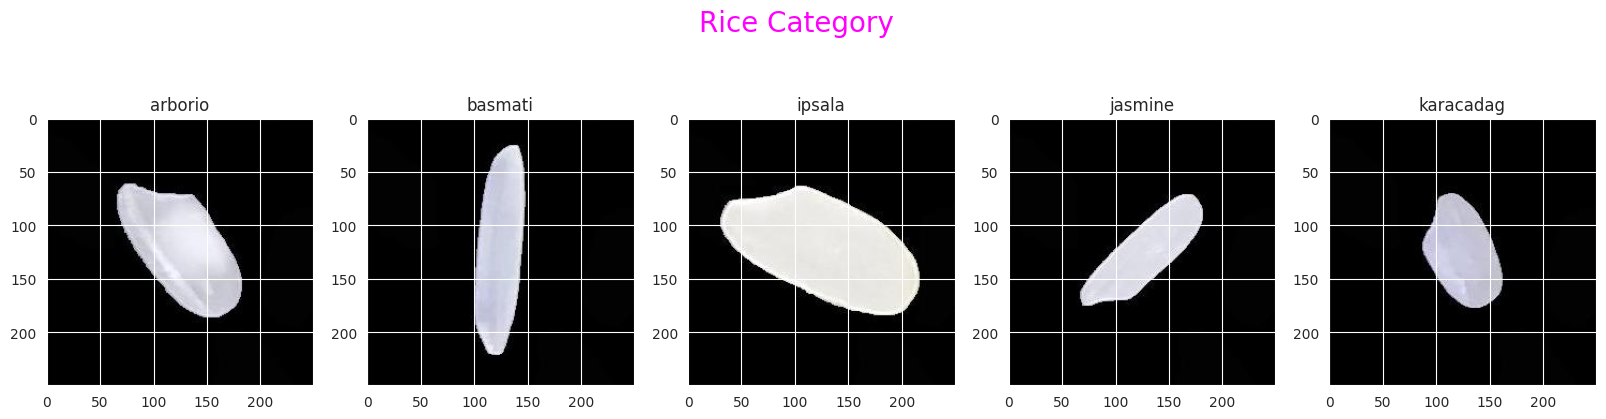

In [ ]:
fig, ax = plt.subplots(ncols=5, figsize=(20,5))
fig.suptitle('Rice Category',color='magenta',fontsize=20)
arborio_img = img.imread(arborio[0])
basmati_img = img.imread(basmati[0])
ipsala_img = img.imread(ipsala[0])
jasmine_img = img.imread(jasmine[0])
karacadag_img = img.imread(karacadag[0])

for index,name in enumerate(list(data.keys())):
    ax[index].set_title(name)
ax[0].imshow(arborio_img)
ax[1].imshow(basmati_img)
ax[2].imshow(ipsala_img)
ax[3].imshow(jasmine_img)
ax[4].imshow(karacadag_img)


<a id="import"></a>
# <p style="background:#45b7ff url('pylogo.jpg') no-repeat; font-family:TimesNewRoman; font-size:100%; color:black; text-align:center; border-radius:20px 30px; width:80%; padding:30px">Phase D: Train & Test Definition</p>

In [ ]:
train_gen=ImageDataGenerator(rescale=1./255,validation_split=0.2)
train_data=train_gen.flow_from_directory(path,target_size=(224,224),batch_size=32,class_mode='categorical',shuffle=True,subset='training')
test_data=train_gen.flow_from_directory(path,target_size=(224,224),batch_size=1,shuffle=False,subset='validation')

Found 60000 images belonging to 5 classes.
Found 15000 images belonging to 5 classes.


<a id="import"></a>
# <p style="background:#ffb7ff url('pylogo.jpg') no-repeat; font-family:TimesNewRoman; font-size:100%; color:black; text-align:center; border-radius:20px 30px; width:80%; padding:30px">Phase E: Creating Simple Model</p>

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam

# Load MobileNetV2 with pre-trained ImageNet weights (excluding the top layers)
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Freeze the base model layers to retain pre-trained features
base_model.trainable = False


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
cnn = Sequential([
    base_model,
    GlobalAveragePooling2D(),  # Replaces Flatten for better feature extraction
    Dense(40, activation='relu'),
    Dropout(0.1),  # No need to specify `seed`
    Dense(5, activation='sigmoid')  # Final output layer for 5 classes
])

In [ ]:
cnn.compile(optimizer=Adam(learning_rate=0.0001),
            loss='categorical_crossentropy',
            metrics=['accuracy'])

cnn.summary()  # Print model summary

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 40)                  │          51,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 40)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             205 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,309,429 (8.81 MB)

 Trainable params: 51,445 (200.96 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
cnn.fit(train_data,epochs=2,validation_data=test_data,shuffle=True)

Epoch 1/2
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 249s 127ms/step - accuracy: 0.8691 - loss: 0.4326 - val_accuracy: 0.9814 - val_loss: 0.0638
Epoch 2/2
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 167s 89ms/step - accuracy: 0.9816 - loss: 0.0652 - val_accuracy: 0.9859 - val_loss: 0.0465


In [ ]:
def plot(c):
    plt.plot(c.history.history['accuracy'],marker='o',color='red',markersize=10)
    plt.plot(c.history.history['val_accuracy'],marker='*',color='green',markersize=10)
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'])
    plt.show()
    plt.plot(c.history.history['loss'],marker='o',color='red',markersize=10)
    plt.plot(c.history.history['val_loss'],marker='*',color='green',markersize=10)
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'])
    plt.show()


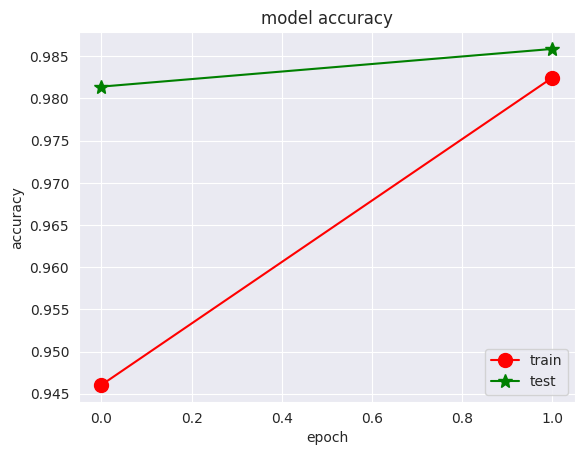

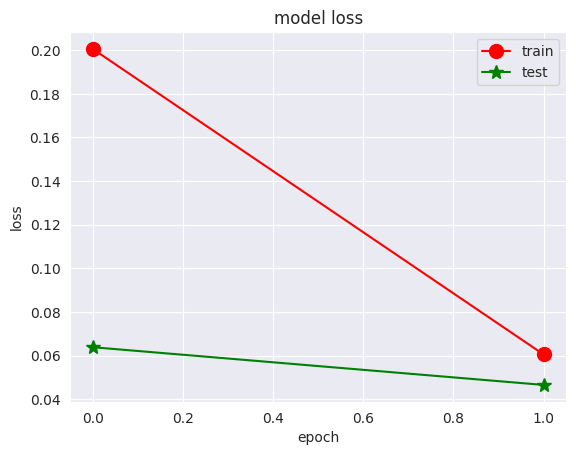

In [ ]:
plot(cnn)

In [ ]:
cnn2 = Sequential([
    base_model,
    GlobalAveragePooling2D(),  # Replaces Flatten for better feature extraction
    Dense(45, activation='relu'),
    Dense(15, activation='relu'),
    Dropout(0.1),  # No need for 'seed'
    Dense(5, activation='sigmoid')  # Output layer for 5 classes
])

In [ ]:
cnn2.compile(optimizer=Adam(learning_rate=0.0001),
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [ ]:
cnn2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 45)                  │          57,645 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 15)                  │             690 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 15)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 5)                   │              80 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,316,399 (8.84 MB)

 Trainable params: 58,415 (228.18 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
cnn2.fit(train_data,epochs=40,validation_data=test_data,shuffle=True,
         callbacks=keras.callbacks.EarlyStopping(monitor="val_loss",patience=10))

Epoch 1/40
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 183s 93ms/step - accuracy: 0.8600 - loss: 0.4974 - val_accuracy: 0.9794 - val_loss: 0.0705
Epoch 2/40
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 164s 88ms/step - accuracy: 0.9702 - loss: 0.0946 - val_accuracy: 0.9844 - val_loss: 0.0526
Epoch 3/40
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 207s 90ms/step - accuracy: 0.9794 - loss: 0.0684 - val_accuracy: 0.9870 - val_loss: 0.0406
Epoch 4/40
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 164s 88ms/step - accuracy: 0.9830 - loss: 0.0570 - val_accuracy: 0.9865 - val_loss: 0.0431
Epoch 5/40
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 166s 88ms/step - accuracy: 0.9848 - loss: 0.0497 - val_accuracy: 0.9880 - val_loss: 0.0395
Epoch 6/40
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 170s 91ms/step - accuracy: 0.9870 - loss: 0.0439 - val_accuracy: 0.9904 - val_loss: 0.0299
Epoch 7/40
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 166s 89ms/step - accuracy: 0.9881 - loss: 0.0376 - val_accuracy: 0.9897 - val_loss: 0.0341
Epoch 8/40
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 168s 89ms/step - accuracy: 

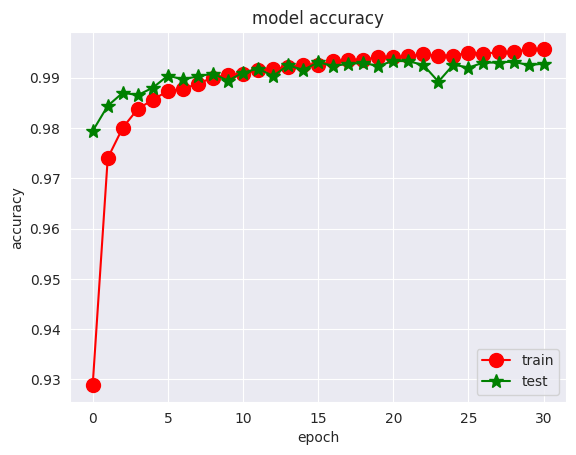

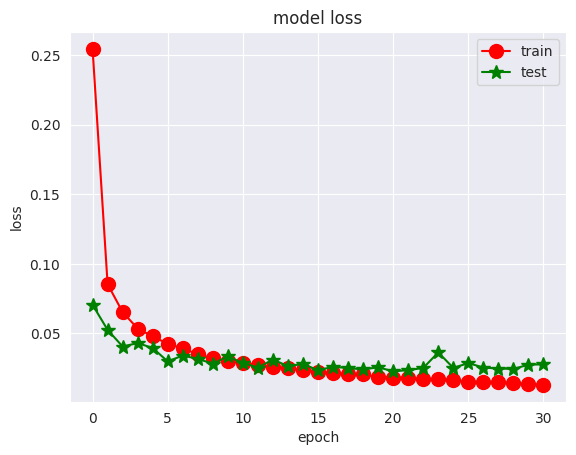

In [ ]:
plot(cnn2)

* __After the model training, seeing the above chart, we conclude that the best **epoch** is **six** for our model, because in this amount, train and test are very close to each other and we have received a good score for the two.

In [ ]:
y_pred = cnn2.predict(test_data)
main_y_pred = np.argmax(y_pred, axis=1)


15000/15000 ━━━━━━━━━━━━━━━━━━━━ 88s 6ms/step


In [ ]:
test_steps_per_epoch = np.math.ceil(test_data.samples / test_data.batch_size)

predictions = cnn2.predict(test_data, steps=test_steps_per_epoch)

# Get most likely class
predicted_classes = np.argmax(predictions, axis=1)

15000/15000 ━━━━━━━━━━━━━━━━━━━━ 88s 6ms/step


In [ ]:
true_classes = test_data.classes
class_labels = list(test_data.class_indices.keys())
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

              precision    recall  f1-score   support

     Arborio       0.99      0.98      0.99      3000
     Basmati       0.99      1.00      1.00      3000
      Ipsala       1.00      1.00      1.00      3000
     Jasmine       0.99      0.99      0.99      3000
   Karacadag       0.98      1.00      0.99      3000

    accuracy                           0.99     15000
   macro avg       0.99      0.99      0.99     15000
weighted avg       0.99      0.99      0.99     15000



array([[2943,    0,    5,    8,   44],
       [   0, 2987,    0,   13,    0],
       [   0,    0, 3000,    0,    0],
       [   3,   16,    3, 2976,    2],
       [  14,    0,    0,    0, 2986]])

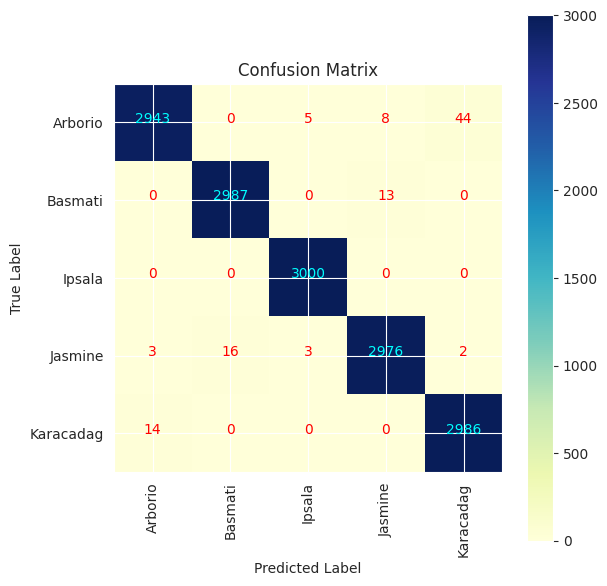

In [ ]:
cm = confusion_matrix(test_data.classes, predicted_classes)
d1=test_data.class_indices
classes = list(d1.keys())
cmap= plt.cm.YlGnBu
plt.figure(figsize= (6, 6))
plt.imshow(cm, interpolation= 'nearest', cmap= cmap)
plt.title('Confusion Matrix')
plt.colorbar(shrink=True)
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 90)
plt.yticks(tick_marks, classes)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'aqua' if cm[i, j] > thresh else 'red')
plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
cm



In [ ]:

train_score = cnn2.evaluate(train_data, verbose= 1)
test_score = cnn2.evaluate(test_data, verbose= 1)
print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('*****************************')
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 79s 41ms/step - accuracy: 0.9978 - loss: 0.0068
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 95s 6ms/step - accuracy: 0.9880 - loss: 0.0491
Train Loss:  0.0063218893483281136
Train Accuracy:  0.9980000257492065
*****************************
Test Loss:  0.02775624208152294
Test Accuracy:  0.9927999973297119


* __Well, in according to the above plot and **Confusion_Matirx** results, we found that our model is good because:

* __the **Accuracy** of **Train** is **0.999** and the **loss** value of it is **0.001** .

* __the **Accuracy** of **Test** is **0.99** and the **loss** value of it is **0.064** and these values are great

* __So that we dont need use **ResNet50** and the other well-known Architecture for this dataset.

### Best Regards!

In [ ]:
cnn2.save("mobilenetv2_model.h5")

In [ ]:
from tensorflow.keras.models import load_model

# Load trained model if not already in memory
model = load_model("mobilenetv2_model.h5")

In [ ]:
import numpy as np
import cv2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Load and preprocess the image
def load_and_preprocess_image(image_path):
    image = cv2.imread(image_path)

    if image is None:
        raise ValueError("Error: Could not load image. Check the file path.")

    # Resize image to match MobileNetV2 input shape (224x224)
    image = cv2.resize(image, (224, 224))

    # Convert to array and preprocess
    image = np.array(image, dtype=np.float32)
    image = preprocess_input(image)

    # Expand dimensions to match model input shape (1, 224, 224, 3)
    image = np.expand_dims(image, axis=0)

    return image


In [ ]:
# Define class labels (modify based on your dataset)

def predict_image(image_path):
    image = load_and_preprocess_image(image_path)

    # Predict class probabilities
    predictions = model.predict(image)

    # Get most likely class index
    predicted_class = np.argmax(predictions, axis=1)[0]

    # Get corresponding class label
    predicted_label = rice_labels[predicted_class]

    print(f"Predicted Class Index: {predicted_class}")
    print(f"Predicted Label: {predicted_label}")
    print(predictions)

# Test on a sample image
image_path = "2.jpg"  # Change this to your image file path
predict_image(image_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Predicted Class Index: 1
Predicted Label: Basmati
[[3.0321084e-05 9.9314260e-01 6.5699273e-09 8.9556283e-01 9.6711260e-04]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


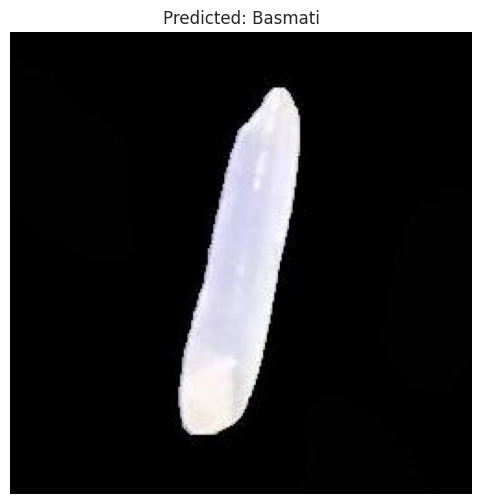

In [ ]:
import matplotlib.pyplot as plt

def display_image_with_prediction(image_path):
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError("Error: Could not load image. Check the file path.")

    # Convert BGR (OpenCV) to RGB (Matplotlib)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Get prediction
    image_processed = load_and_preprocess_image(image_path)
    predictions = model.predict(image_processed)
    predicted_class = np.argmax(predictions, axis=1)[0]
    predicted_label = rice_labels[predicted_class]

    # Display image with predicted label
    plt.figure(figsize=(6, 6))
    plt.imshow(image_rgb)
    plt.axis("off")
    plt.title(f"Predicted: {predicted_label}")
    plt.show()

# Display test image with prediction
display_image_with_prediction(image_path)
